In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.io as io
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {device}")

model = models.convnext_large(weights="IMAGENET1K_V1")
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, 14)
model = model.to(device)
print("✅ Modelo ConvNeXt-Large cargado y adaptado")

def save_checkpoint(epoch, model, optimizer, path="checkpoint_multi.pth"):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(state, path)
    print(f"💾 Checkpoint guardado en la época {epoch}.")

def load_checkpoint(model, optimizer, path="checkpoint_multi.pth"):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint cargado desde la época {start_epoch}.")
        return start_epoch
    else:
        print("No se encontró checkpoint. Entrenando desde la época 0.")
        return 0

# Tranformacion basica
basic_transform = transforms.Compose([
    transforms.Resize((384, 384), antialias=True)
])


class FractureDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["ruta"]
        label = int(self.df.iloc[idx]["clase"])

        image = io.read_image(img_path)
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        image = image.float() / 255.0  # escalar a [0, 1]

        if self.transform:
            image = self.transform(image)

        return image.to(device), torch.tensor(label, dtype=torch.long, device=device)

train_csv = "G:/Mi unidad/TESIS/MURA-v1.1/train_multiclase.csv"
valid_csv = "G:/Mi unidad/TESIS/MURA-v1.1/valid_multiclase.csv"

train_dataset = FractureDataset(train_csv, transform=basic_transform)
valid_dataset = FractureDataset(valid_csv, transform=basic_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

print("✅ DataLoaders listos")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

start_epoch = load_checkpoint(model, optimizer)


for param in model.features.parameters():
    param.requires_grad = False

EPOCHS = 30

scaler = torch.cuda.amp.GradScaler()

for epoch in range(start_epoch, EPOCHS):

    model.train()

    # Fine-tuning progresivo
    if epoch == 3:
        for param in model.features[-10:].parameters():
            param.requires_grad = True
        optimizer.param_groups[0]['lr'] = 5e-5

    if epoch == 8:
        for param in model.features.parameters():
            param.requires_grad = True
        optimizer.param_groups[0]['lr'] = 1e-5

    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Época {epoch+1}/{EPOCHS}")

    for images, labels in loop:
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)  # [B, 14]
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        loop.set_postfix(loss=train_loss, acc=train_acc)

    scheduler.step()

    print(f"📈 Epoch {epoch+1} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    save_checkpoint(epoch, model, optimizer)

torch.save(model.state_dict(), "Modelo_multiclase.pth")
print("✅ Modelo multiclase guardado")


✅ Usando dispositivo: cuda
✅ Modelo ConvNeXt-Large cargado y adaptado
✅ DataLoaders listos
Checkpoint cargado desde la época 10.


Época 11/30: 100%|██████████| 2301/2301 [16:24<00:00,  2.34it/s, acc=0.879, loss=0.317]


📈 Epoch 11 | Loss: 0.3169 | Accuracy: 0.8790
💾 Checkpoint guardado en la época 10.


Época 12/30: 100%|██████████| 2301/2301 [16:21<00:00,  2.34it/s, acc=0.885, loss=0.302]


📈 Epoch 12 | Loss: 0.3018 | Accuracy: 0.8850
💾 Checkpoint guardado en la época 11.


Época 13/30: 100%|██████████| 2301/2301 [16:23<00:00,  2.34it/s, acc=0.886, loss=0.295]


📈 Epoch 13 | Loss: 0.2948 | Accuracy: 0.8862
💾 Checkpoint guardado en la época 12.


Época 14/30: 100%|██████████| 2301/2301 [16:24<00:00,  2.34it/s, acc=0.888, loss=0.288]


📈 Epoch 14 | Loss: 0.2879 | Accuracy: 0.8880
💾 Checkpoint guardado en la época 13.


Época 15/30: 100%|██████████| 2301/2301 [16:25<00:00,  2.34it/s, acc=0.89, loss=0.284] 


📈 Epoch 15 | Loss: 0.2836 | Accuracy: 0.8902
💾 Checkpoint guardado en la época 14.


Época 16/30: 100%|██████████| 2301/2301 [16:23<00:00,  2.34it/s, acc=0.89, loss=0.282] 


📈 Epoch 16 | Loss: 0.2824 | Accuracy: 0.8904
💾 Checkpoint guardado en la época 15.


Época 17/30: 100%|██████████| 2301/2301 [16:22<00:00,  2.34it/s, acc=0.891, loss=0.281]


📈 Epoch 17 | Loss: 0.2809 | Accuracy: 0.8909
💾 Checkpoint guardado en la época 16.


Época 18/30: 100%|██████████| 2301/2301 [16:22<00:00,  2.34it/s, acc=0.894, loss=0.278]


📈 Epoch 18 | Loss: 0.2784 | Accuracy: 0.8940
💾 Checkpoint guardado en la época 17.


Época 19/30: 100%|██████████| 2301/2301 [16:23<00:00,  2.34it/s, acc=0.892, loss=0.28]  


📈 Epoch 19 | Loss: 0.2796 | Accuracy: 0.8916
💾 Checkpoint guardado en la época 18.


Época 20/30: 100%|██████████| 2301/2301 [16:23<00:00,  2.34it/s, acc=0.893, loss=0.276]


📈 Epoch 20 | Loss: 0.2760 | Accuracy: 0.8928
💾 Checkpoint guardado en la época 19.


Época 21/30: 100%|██████████| 2301/2301 [16:24<00:00,  2.34it/s, acc=0.891, loss=0.281]


📈 Epoch 21 | Loss: 0.2808 | Accuracy: 0.8910
💾 Checkpoint guardado en la época 20.


Época 22/30: 100%|██████████| 2301/2301 [16:24<00:00,  2.34it/s, acc=0.895, loss=0.277]


📈 Epoch 22 | Loss: 0.2767 | Accuracy: 0.8946
💾 Checkpoint guardado en la época 21.


Época 23/30: 100%|██████████| 2301/2301 [16:26<00:00,  2.33it/s, acc=0.894, loss=0.274]


📈 Epoch 23 | Loss: 0.2744 | Accuracy: 0.8937
💾 Checkpoint guardado en la época 22.


Época 24/30: 100%|██████████| 2301/2301 [16:25<00:00,  2.33it/s, acc=0.896, loss=0.271] 


📈 Epoch 24 | Loss: 0.2713 | Accuracy: 0.8955
💾 Checkpoint guardado en la época 23.


Época 25/30: 100%|██████████| 2301/2301 [16:26<00:00,  2.33it/s, acc=0.895, loss=0.271]


📈 Epoch 25 | Loss: 0.2705 | Accuracy: 0.8950
💾 Checkpoint guardado en la época 24.


Época 26/30: 100%|██████████| 2301/2301 [16:29<00:00,  2.33it/s, acc=0.897, loss=0.267]


📈 Epoch 26 | Loss: 0.2674 | Accuracy: 0.8969
💾 Checkpoint guardado en la época 25.


Época 27/30: 100%|██████████| 2301/2301 [16:28<00:00,  2.33it/s, acc=0.897, loss=0.266] 


📈 Epoch 27 | Loss: 0.2662 | Accuracy: 0.8972
💾 Checkpoint guardado en la época 26.


Época 28/30: 100%|██████████| 2301/2301 [16:27<00:00,  2.33it/s, acc=0.898, loss=0.266]


📈 Epoch 28 | Loss: 0.2663 | Accuracy: 0.8979
💾 Checkpoint guardado en la época 27.


Época 29/30: 100%|██████████| 2301/2301 [16:26<00:00,  2.33it/s, acc=0.9, loss=0.263]   


📈 Epoch 29 | Loss: 0.2628 | Accuracy: 0.9002
💾 Checkpoint guardado en la época 28.


Época 30/30: 100%|██████████| 2301/2301 [16:25<00:00,  2.33it/s, acc=0.898, loss=0.263]


📈 Epoch 30 | Loss: 0.2626 | Accuracy: 0.8981
💾 Checkpoint guardado en la época 29.
✅ Modelo multiclase guardado


In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo base
model = models.convnext_large(weights="IMAGENET1K_V1")
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 14)  # multiclase

# Cargar pesos desde la misma carpeta del notebook
model.load_state_dict(torch.load("Modelo_multiclase.pth", map_location=device))
model = model.to(device)
model.eval()

print("✅ Modelo cargado correctamente")


✅ Modelo cargado correctamente


In [ ]:
from sklearn.metrics import classification_report
NUM_CLASSES=14

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ===============================
# Reporte de clasificación
# ===============================
target_names = [f"Clase {i}" for i in range(NUM_CLASSES)]
reporte = classification_report(all_labels, all_preds, target_names=target_names, digits=3)

print("📊 Reporte de Clasificación:\n")
print(reporte)


📊 Reporte de Clasificación:

              precision    recall  f1-score   support

     Clase 0      0.827     0.821     0.824       285
     Clase 1      0.799     0.817     0.808       278
     Clase 2      0.797     0.868     0.831       235
     Clase 3      0.817     0.813     0.815       230
     Clase 4      0.735     0.869     0.797       214
     Clase 5      0.902     0.709     0.794       247
     Clase 6      0.741     0.860     0.796       150
     Clase 7      0.899     0.589     0.712       151
     Clase 8      0.773     0.919     0.840       271
     Clase 9      0.803     0.624     0.702       189
    Clase 10      0.872     0.831     0.851       148
    Clase 11      0.865     0.871     0.868       140
    Clase 12      0.811     0.942     0.872       364
    Clase 13      0.892     0.759     0.821       295

    accuracy                          0.816      3197
   macro avg      0.824     0.807     0.809      3197
weighted avg      0.823     0.816     0.814      31

**CURVA ROC EN FORMATO IMAGEN**

In [ ]:
import os
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import gc

# Crear carpeta de salida si no existe
os.makedirs("roc_por_clase", exist_ok=True)

# Convertir etiquetas a one-hot
y_true = label_binarize(np.array(all_labels), classes=list(range(NUM_CLASSES)))
y_score = np.array(all_probs)

# ROC y AUC por clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Crear gráfico individual para la clase i
    plt.figure(figsize=(6, 5))
    plt.plot(fpr[i], tpr[i], color='blue', lw=2, label=f"AUC = {roc_auc[i]:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Falsos Positivos")
    plt.ylabel("Verdaderos Positivos")
    plt.title(f"Curva ROC - Clase {i}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()

    # Guardar la figura
    ruta_figura = f"roc_por_clase/roc_clase_{i}.png"
    plt.savefig(ruta_figura)
    plt.close()
    print(f"✅ Curva ROC guardada para Clase {i} → {ruta_figura}")

gc.collect()


✅ Curva ROC guardada para Clase 0 → roc_por_clase/roc_clase_0.png
✅ Curva ROC guardada para Clase 1 → roc_por_clase/roc_clase_1.png
✅ Curva ROC guardada para Clase 2 → roc_por_clase/roc_clase_2.png
✅ Curva ROC guardada para Clase 3 → roc_por_clase/roc_clase_3.png
✅ Curva ROC guardada para Clase 4 → roc_por_clase/roc_clase_4.png
✅ Curva ROC guardada para Clase 5 → roc_por_clase/roc_clase_5.png
✅ Curva ROC guardada para Clase 6 → roc_por_clase/roc_clase_6.png
✅ Curva ROC guardada para Clase 7 → roc_por_clase/roc_clase_7.png
✅ Curva ROC guardada para Clase 8 → roc_por_clase/roc_clase_8.png
✅ Curva ROC guardada para Clase 9 → roc_por_clase/roc_clase_9.png
✅ Curva ROC guardada para Clase 10 → roc_por_clase/roc_clase_10.png
✅ Curva ROC guardada para Clase 11 → roc_por_clase/roc_clase_11.png
✅ Curva ROC guardada para Clase 12 → roc_por_clase/roc_clase_12.png
✅ Curva ROC guardada para Clase 13 → roc_por_clase/roc_clase_13.png


45

**MATRIZ DE CONFUSION**

C:\Users\SKACE\AppData\Local\Temp\ipykernel_23304\4222074219.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\SKACE\AppData\Local\Temp\ipykernel_23304\4222074219.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig("matriz_confusion.png")
C:\Users\SKACE\anaconda3\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


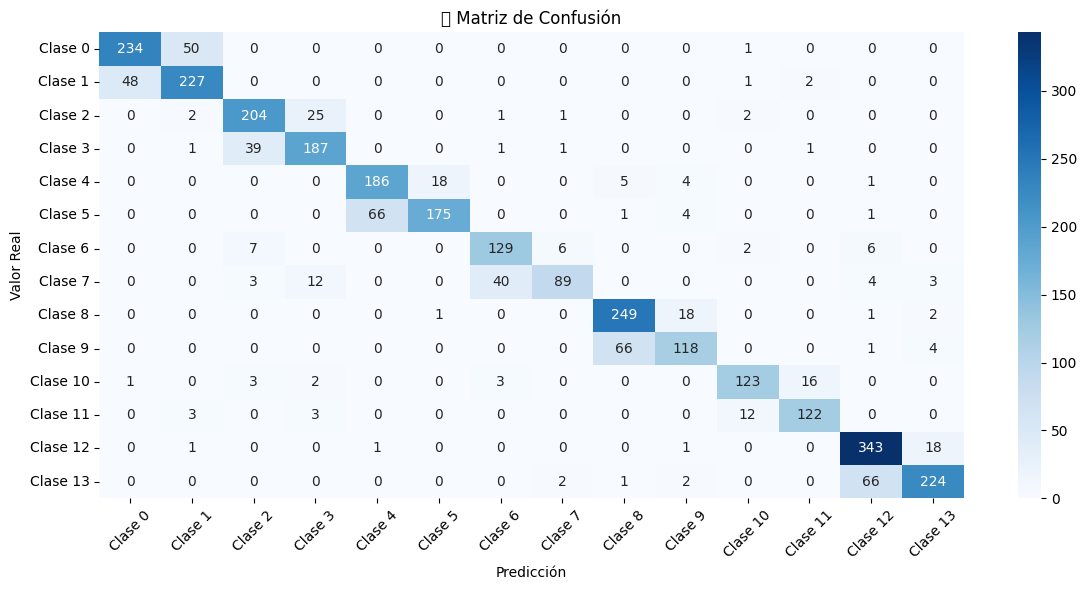

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Asegúrate de tener estas listas ya preparadas:
# all_labels → etiquetas verdaderas (enteros)
# all_preds  → predicciones del modelo (enteros)

# ===============================
# Matriz de confusión
# ===============================
cm = confusion_matrix(all_labels, all_preds)
labels = [f"Clase {i}" for i in range(NUM_CLASSES)]

plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("📊 Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("matriz_confusion.png")
plt.show()
